# Defining Column Roles with NimbusML - Relevance Judgement

In nimbusml, when developing a pipeline, (usually for the last learner) users can specify the column roles, such as feature, label, weight, group (for ranking problem), etc.. With this definition, a full dataset with all thoses columns can be fed to the training function. The learner will extract the useful columns from the dataset automatically.

In this tutorial, we solve a learning to rank problem using Microsoft Bing data. More specifically, it is a Subset Ranking problem with real-valued relevance labels. The full dataset is available online (www.microsoft.com/en-us/research/project/mslr). Queries and urls provided by a web search engine (Microsoft Bing) are presented as pairs (see the following figure). Each query-url pair is then evaluated by relevence, which takes 5 values (0 for irrelevenat and 4 for perfectly relevant), serving as the label for this machine learning problem. Features are extracted by the Bing team, and those include term frequencies, length of url, etc. for each query-url pair. The model aims at predicting the scores of each pair that in the same order as the relevance within the same group.

In this notebook, due to license issues, we use a randomly generated ranking data just to demonstrate the usage of the package.

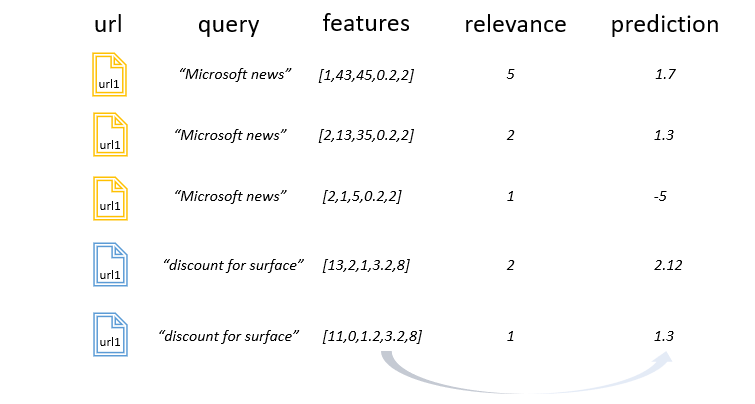

In [1]:
from IPython.display import display,IFrame,Image
display(Image(filename='images/Ranking2.PNG'))

## Loading Data

In [2]:
# Getting input file path from package
# Due to licensing, user needs to download data files himself
import os
import numpy as np
import pandas as pd
from nimbusml.datasets import get_dataset
from nimbusml import FileDataStream, Role, Pipeline
from nimbusml.ensemble import LightGbmRanker
from nimbusml.preprocessing import ToKey

train_file = get_dataset('msltrtrain').as_filepath()
test_file = get_dataset('msltrtest').as_filepath()

A snapshot of the input training data is shown below:

|Relevance|QueryID|CoveredQueryTermNumber-Body|StreamLength-Body|InverseDocumentFrequency-Body|SumOfTermFrequency-Title|QualityScore|
|-----|----------|--------------|-------|--------|-------------|------|
|2|1|3|156|6.94|2|1|
|3|1|3|406|6.94|1|3|
|2|6|3|146|10.22|6|3|
|5|6|3|209|10.22|4|23|

Each row corresponds to a url-query pair. The first column is the relevance for the url to the corresponding query. The first and second rows are for the same query, but the second url has higher relavance score than the first one. The second column is the query id. The rest columns include the features for this url-query pair. There are 136 features in total, some of which are not shown here. The ranking model predicts the relevance label for each url-query pair.

We generate the schema and create DataFileStream.

In [3]:
train_stream = FileDataStream.read_csv(
                                        train_file, sep = ',', 
                                        header = False, 
                                        collapse=True, 
                                        names={0:'Label', 1:'GroupId', (2,137):'Features'}, 
                                        numeric_dtype=np.float32, dtype={'GroupId':str})
test_stream = FileDataStream.read_csv(
                                        test_file, 
                                        sep = ',', 
                                        header = False, 
                                        collapse=True, 
                                        names={0:'Label', 1:'GroupId', (2,137):'Features'}, 
                                        numeric_dtype=np.float32, 
                                        dtype={'GroupId':str})

## Training

In [4]:
model = Pipeline([
                    ToKey(columns = 'GroupId'), #If we can generate schema setting GroupId:U4, we don't need this
                    LightGbmRanker(feature="Features", label='Label', group_id='GroupId')
                ])
model.fit(train_stream, 'Label');

Not adding a normalizer.
Auto-tuning parameters: UseCat = False
Auto-tuning parameters: LearningRate = 0.2
Auto-tuning parameters: NumLeaves = 20
Auto-tuning parameters: MinDataPerLeaf = 20
LightGBM objective=lambdarank
Not training a calibrator because it is not needed.
Elapsed time: 00:00:02.1925737


Notice that we add a ToKey transform for the GroupId column. The original dataset has column GroupId as string. However, for LightGbmRanker, the group_id column must be a 'key' type. Therefore, we add this tranformation.

The above code identifies the feature, label and the group_id for LightGbmRanker(). The loss function is estimated per group, and the group_id is needed for each query-url pair. In this case, the group_id is the same as the query id. 

There are three ways to specify those roles for different columns, other than the syntax above, the following syntax is also allowed:
        
        from nimbusml import Role
        model = LightGbmRanker() << {Role.Feature: 'Features', Role.Label: 'Label', Role.GroupId: 'GroupID'}
        model = LightGbmRanker(columns = {Role.Feature: 'Features', Role.Label: 'Label', Role.GroupId: 'GroupID'})
Not only for ranking problems, the same syntax can also be used for classificaion, regression, etc.. In the fitting function, no "y" will be needed as long as all the columns are included in the training dataset (either a dataframe or a FileDataStream).

## Evaluation

Similar to other examples with pipeline, the model can be evaluated using .test(). A perfect ranking model would predict higher score for url-query pair with high relevance. We can see from the above table that all the test samples belong to the same query. Urls have higher relevance tend to have higher score. Note that the model is only trained with 100 rows of data and should be improved with large sample size.

In [5]:
# scores, metrics = model.test(test_stream, evaltype='ranking') #Error, but I would expect this to work as model.fit()
metrics, scores = model.test(test_stream, 'Label', group_id = 'GroupId', evaltype='ranking', output_scores = True)

import pandas as pd
scores[['Relevance','QueryID']] = pd.read_csv(test_file, header = None)[[0,1]]

print("Prediction scores: ")
scores[0:10]

Prediction scores: 


,Score,Relevance,QueryID
0,-0.282313,2,5
1,1.316929,1,5
2,1.010535,1,5
3,-2.374678,0,5
4,-0.597613,0,5
5,-0.769006,0,5
6,-1.339494,1,5
7,-0.869256,1,5
8,-1.418283,0,5
9,0.012214,0,5


## Discussion

The Normalized Discounted Cumulative Gain (NDCG) and Discounted Cumulative Gain (DCG) at a particular rank position (1,2, or 3) are reported by the .test() function if setting evaltype='ranking'. DCG evaluates the quality of a rank with respect to the original relevance scores. It is the sum of the relevance scores for the top N items in the ranking, and it can be computed as follows: 

<img src="images/2-5-1.png" align = "middle"/>
  
Where N is the threshold of ranking to account for in DCG, and g<sub>i</sub> the relavance score for the i<sup>th</sup> item in the ranking. The NDCG is simply calculated by normalizing the DCG by Max_DCG, which is the DCG for the perfect ranking (all the items are sorted by relevance score).

In [6]:
print("Performance Metrics: ")
metrics

Performance Metrics: 


,NDCG@1,NDCG@2,NDCG@3,DCG@1,DCG@2,DCG@3
0,20,20,22.860827,4.328085,7.058803,9.222845
